In [18]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [19]:
#Loading MNIST Dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 *2 -1, x_test / 255.0 *2 -1

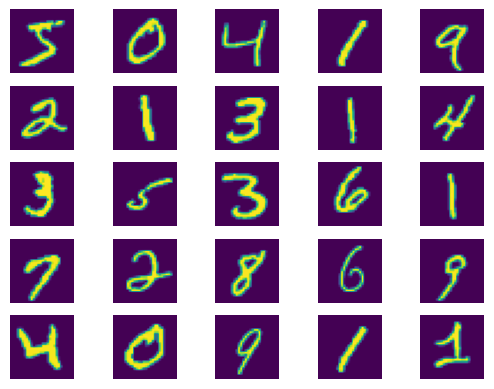

In [21]:
#Plot some example images from the training datasets

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(x_train[i])
plt.show()

In [22]:
#Flattening 3D datasets to 2D datasets and converting the image size from 28*28 to 684
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [23]:
latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i, x)
  return model

In [24]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [25]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Build the generator
generator = build_generator(latent_dim)

In [26]:
#Create Noise Sample
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

In [27]:
#Create Generator Model
combined_model_gen = Model(z, fake_pred)
#Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [28]:
#Define the parameters for training GAN
batch_size = 32
epochs = 5000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#Store generator and discriminator loss in each epoch
g_losses = []
d_losses = []
#Create a file for generator to create and save images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [29]:
#Create sample images
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):  #5*5 loop implies there will be 25 images on page
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [30]:
#Train the discriminator followed by the generator to generate images
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size) #Select a random batch of images
  real_imgs = x_train[idx] #Train the discriminator

  noise = np.random.randn(batch_size, latent_dim)  #Generator for generating fake images
  fake_imgs = generator.predict(noise)

  #Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #Both loss and accuracy are returned for the real images
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #Both loss and accuracy are returned for the fake images
  d_loss = 0.5 * (d_loss_real + d_loss_fake) #Average loss
  d_acc  = 0.5 * (d_acc_real + d_acc_fake) #Average accuracy

  #Train the generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  #Here we are attempting to fool the discriminator that the generated images are real. Due to this reason, we are labeling it as 1
  #Repeat the step!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  d_losses.append(d_loss)  #Save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step
epoch: 101/5000, d_loss: 0.04, d_acc: 1.00, g_loss: 3.83
1/1 [==============================] - 0s 16ms/step
epoch: 201/5000, d_loss: 0.54, d_acc: 0.58, g_loss: 1.39
1/1 [==============================] - 0s 21ms/step
epoch: 301/5000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.60
1/1 [==============================] - 0s 17ms/step
epoch: 401/5000, d_loss: 0.69, d_acc: 0.48, g_loss: 0.63
1/1 [==============================] - 0s 14ms/step
epoch: 501/5000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.63
1/1 [==============================] - 0s 23ms/step
epoch: 601/5000, d_loss: 0.67, d_acc: 0.52, g_loss: 0.66
1/1 [==============================] - 0s 29ms/step
epoch: 701/5000, d_loss: 0.68, d_acc: 0.52, g_loss: 0.70
1/1 [==============================] - 0s 16ms/step
epoch: 801/5000, d_loss: 0.64, d_acc: 0.59, g_loss: 0.72
1/1 [==============================] - 0s 14ms/step
epoch: 901/5000, d_loss: 

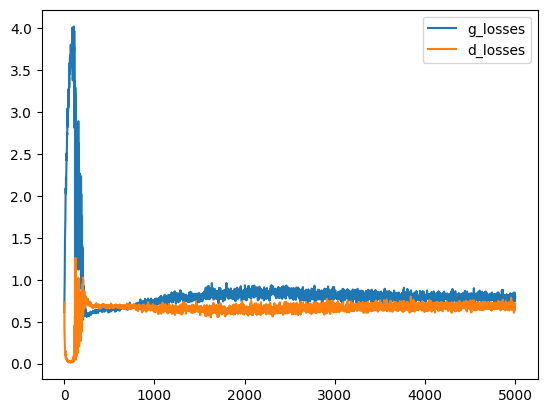

In [31]:
#Plot the loss function
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

**Observe the results**

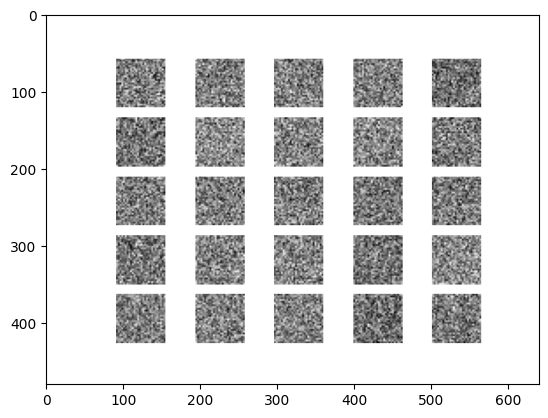

In [32]:
#Plot the generated image at 0 epoch

from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

**Observation:** There is no information that can be extracted from the generator, whereas the discriminator is capable enough to identify the fake case.

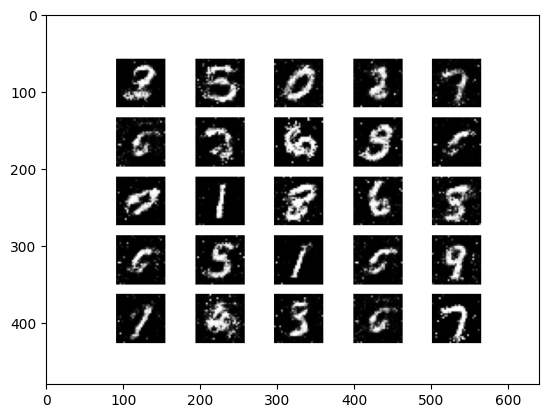

In [35]:
#Plot the generated image at 4000 epoch

from skimage.io import imread
a = imread('gan_images/4000.png')
plt.imshow(a)

**Observation:** The generator has built the images almost with the same qualities as the MNIST dataset, which increases the chances of making the discriminator fool.